In [3]:
!pip install monai==0.6

In [4]:
import os
import sys
import time
import math
import copy
import torch
from torch import nn as nn
import numpy as np
from matplotlib import pyplot as plt
from easydict import EasyDict
from typing import List, Dict, Union, Sequence, Callable

from monai.data import DataLoader, CacheDataset, decollate_batch
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    Randomizable,
    Resized,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    ToTensord,
)
from monai.utils import set_determinism

2024-06-29 12:44:36.934823: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-29 12:44:36.935427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-29 12:44:37.060954: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
cfg = EasyDict()
cfg.epoch = 100
cfg.learning_rate = 1e-4
cfg.weight_decay = 1e-5
cfg.patience = 10
cfg.unetr = EasyDict()
cfg.unetr.img_shape = (96, 96, 96)
cfg.unetr.input_dim = 4
cfg.unetr.output_dim = 3
cfg.unetr.patch_size = 16
cfg.unetr.embed_dim = 768
cfg.unetr.num_layers = 12
cfg.unetr.num_heads = 12
cfg.unetr.mlp_dim = 2048
cfg.unetr.extract_layers = [3, 6, 9, 12]

# Setup data directory

In [6]:
root_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
output_dir = "/kaggle/working/"

In [7]:
set_determinism(seed=0)

In [8]:
class SingleDeconv3DBlock(nn.Module):
    '''
    The green box in the architecture
    '''
    def __init__(self, in_planes, out_planes):
        super().__init__()
        self.block = nn.ConvTranspose3d(in_planes, out_planes, kernel_size=2, stride=2, padding=0, output_padding=0)

    def forward(self, x):
        return self.block(x)

In [9]:
class SingleConv3DBlock(nn.Module):
    '''
    The gray box in the architecture
    '''
    def __init__(self, in_planes, out_planes, kernel_size):
        super().__init__()
        self.block = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                               padding=((kernel_size - 1) // 2))

    def forward(self, x):
        return self.block(x)

In [10]:
class Conv3DBlock(nn.Module):
    '''
    The yellow box in the architecture
    Cnv3d 3x3x3 + Batch Normalization + ReLU
    '''
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleConv3DBlock(in_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)

In [11]:
class Deconv3DBlock(nn.Module):
    '''
    The blue box in the architecture
    Deconv 2x2x2 + Conv 3x3x3 + Batch Normalization + ReLU
    '''
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleDeconv3DBlock(in_planes, out_planes),
            SingleConv3DBlock(out_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)

# Transformer classes

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, embed_dim, dropout):
        super().__init__()
        self.num_attention_heads = num_heads
        self.attention_head_size = int(embed_dim / num_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.query = nn.Linear(embed_dim, self.all_head_size)
        self.key = nn.Linear(embed_dim, self.all_head_size)
        self.value = nn.Linear(embed_dim, self.all_head_size)

        self.out = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)

        self.softmax = nn.Softmax(dim=-1)

        self.vis = False

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)

        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights

In [13]:
class MLP(nn.Module):
    def __init__(self, embedding_dim, mlp_dim):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(mlp_dim, embedding_dim),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        x = self.mlp(x)
        return x

In [14]:
class Embeddings(nn.Module):
    def __init__(self, input_dim, embed_dim, cube_size, patch_size, dropout):
        super().__init__()
        self.n_patches = int((cube_size[0] * cube_size[1] * cube_size[2]) / (patch_size * patch_size * patch_size))
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        # They used convolution operation for making patches. Where kernel size is the patch_size, anstride is patch_size.
        # In normal ViT, there is a flattening layer followed by a Dense layer"
        self.patch_embeddings = nn.Conv3d(in_channels=input_dim, out_channels=embed_dim,
                                          kernel_size=patch_size, stride=patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, self.n_patches, embed_dim))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.patch_embeddings(x)
        x = x.flatten(2) # the output of conv layer(a matrix) is then flattened.
        x = x.transpose(-1, -2)
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings

In [15]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout, cube_size, patch_size):
        super().__init__()
        self.attention_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp_dim = int((cube_size[0] * cube_size[1] * cube_size[2]) / (patch_size * patch_size * patch_size))
        self.mlp = MLP(embed_dim, cfg.unetr.mlp_dim)
        self.attn = MultiHeadAttention(num_heads, embed_dim, dropout)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h
        
        h = x
        x = self.mlp_norm(x)
        x = self.mlp(x)
        x = x + h
        
        return x, weights

In [16]:
class Transformer(nn.Module):
    def __init__(self, input_dim, embed_dim, cube_size, patch_size, num_heads, num_layers, dropout, extract_layers):
        super().__init__()
        self.embeddings = Embeddings(input_dim, embed_dim, cube_size, patch_size, dropout)
        self.layer = nn.ModuleList()
        self.encoder_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.extract_layers = extract_layers
        for _ in range(num_layers):
            layer = TransformerBlock(embed_dim, num_heads, dropout, cube_size, patch_size)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, x):
        extract_layers = []
        hidden_states = self.embeddings(x)

        for depth, layer_block in enumerate(self.layer):
            hidden_states, _ = layer_block(hidden_states)
            if depth + 1 in self.extract_layers:
                extract_layers.append(hidden_states)

        return extract_layers

In [17]:
class UNETR(nn.Module):
    def __init__(self, img_shape=cfg.unetr.img_shape, input_dim=cfg.unetr.input_dim, output_dim=cfg.unetr.output_dim, embed_dim=cfg.unetr.embed_dim, patch_size=cfg.unetr.patch_size, num_heads=cfg.unetr.num_heads, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.num_layers = cfg.unetr.num_layers
        self.ext_layers = cfg.unetr.extract_layers

        self.patch_dim = [int(x / patch_size) for x in img_shape]

        # Transformer Encoder
        self.transformer = \
            Transformer(
                input_dim=input_dim,
                embed_dim=embed_dim,
                cube_size=img_shape,
                patch_size=patch_size,
                num_heads=num_heads,
                num_layers=self.num_layers,
                dropout=dropout,
                extract_layers=self.ext_layers
            )

        # U-Net Decoder
        self.decoder0 = \
            nn.Sequential(
                Conv3DBlock(input_dim, 32, 3),
                Conv3DBlock(32, 64, 3)
            )

        self.decoder3 = \
            nn.Sequential(
                Deconv3DBlock(embed_dim, 512),
                Deconv3DBlock(512, 256),
                Deconv3DBlock(256, 128)
            )

        self.decoder6 = \
            nn.Sequential(
                Deconv3DBlock(embed_dim, 512),
                Deconv3DBlock(512, 256),
            )

        self.decoder9 = \
            Deconv3DBlock(embed_dim, 512)

        self.decoder12_upsampler = \
            SingleDeconv3DBlock(embed_dim, 512)

        self.decoder9_upsampler = \
            nn.Sequential(
                Conv3DBlock(1024, 512),
                Conv3DBlock(512, 512),
                Conv3DBlock(512, 512),
                SingleDeconv3DBlock(512, 256)
            )

        self.decoder6_upsampler = \
            nn.Sequential(
                Conv3DBlock(512, 256),
                Conv3DBlock(256, 256),
                SingleDeconv3DBlock(256, 128)
            )

        self.decoder3_upsampler = \
            nn.Sequential(
                Conv3DBlock(256, 128),
                Conv3DBlock(128, 128),
                SingleDeconv3DBlock(128, 64)
            )

        self.decoder0_header = \
            nn.Sequential(
                Conv3DBlock(128, 64),
                Conv3DBlock(64, 64),
                SingleConv3DBlock(64, output_dim, 1)
            )

    def forward(self, x):
        z = self.transformer(x)
        z0, z3, z6, z9, z12 = x, *z
        z3 = z3.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z6 = z6.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z9 = z9.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z12 = z12.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)

        z12 = self.decoder12_upsampler(z12)
        z9 = self.decoder9(z9)
        z9 = self.decoder9_upsampler(torch.cat([z9, z12], dim=1))
        z6 = self.decoder6(z6)
        z6 = self.decoder6_upsampler(torch.cat([z6, z9], dim=1))
        z3 = self.decoder3(z3)
        z3 = self.decoder3_upsampler(torch.cat([z3, z6], dim=1))
        z0 = self.decoder0(z0)
        output = self.decoder0_header(torch.cat([z0, z3], dim=1))
        return output

In [ ]:
import os
import shutil

# Specify the path to the Kaggle output directory
output_dir = '/kaggle/working'

# Check if the directory exists
if os.path.exists(output_dir):
    # Iterate over all the files and directories in the output directory
    for filename in os.listdir(output_dir):
        file_path = os.path.join(output_dir, filename)
        
        try:
            # Check if it is a file or a directory
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove file or link
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove directory and its contents
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')
else:
    print(f'The directory {output_dir} does not exist.')


In [18]:
def plot_data_distribution(num_train: int, num_val: int, num_test: int):
    """Plot number of data for train-set, val-set, and test-set after splitted"""

    # Create the bar chart
    bars = plt.bar(["Train", "Val", "Test"],
            [num_train, num_val, num_test], align='center', color=['green', 'red', 'blue'])

    # Add the data value on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()


def load_datalist(
    root_dir: str
) -> List[Dict]:
    """
    Load image/label paths of dataset
    """
    
    datalist = []
    for data in os.listdir(root_dir):
        data_dir_path = os.path.join(root_dir, data)
        if os.path.isdir(data_dir_path):
            model_scans = ["flair", "t1", "t1ce", "t2"]
            image_paths = [os.path.join(data_dir_path, f"{data}_{model}.nii") for model in model_scans]
            label_path = os.path.join(data_dir_path, f"{data}_seg.nii")

            if (all(os.path.exists(path) for path in [*image_paths, label_path])):
                datalist.append({
                    "image": image_paths,
                    "label": label_path
                })

    return datalist


class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the necrotic and non-enhancing tumor core
    label 2 is the peritumoral edema
    label 4 is the GD-enhancing tumor
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 1 and label 4 to construct TC
            result.append(np.logical_or(d[key] == 1, d[key] == 4))
            # merge labels 1, 2 and 4 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 1, d[key] == 4), d[key] == 2
                )
            )
            # label 4 is ET
            result.append(d[key] == 4)
            d[key] = np.stack(result, axis=0).astype("float32")
        return d
    
    
class BratsDataset(Randomizable, CacheDataset):
    """
    Generate items for training, validation or test.
    """

    def __init__(
        self,
        root_dir: str,
        section: str,
        transform: Union[Sequence[Callable], Callable] = (),
        val_frac: float = 0.15,
        test_frac: float = 0.05,
        seed: int = 0,
        cache_num: int = sys.maxsize,
        cache_rate: float = 1.0,
        num_workers: int = 0,
    ) -> None:
        if not os.path.isdir(root_dir) or not os.path.exists(root_dir):
            raise RuntimeError(
                f"Cannot find dataset directory: {root_dir}."
            )

        self.section = section
        self.val_frac = val_frac
        self.test_frac = test_frac
        self.set_random_state(seed=seed)
        self.indices: np.ndarray = np.array([])
        
        data = self._generate_data_list(root_dir)
        CacheDataset.__init__(
            self, data, transform, cache_num=cache_num, cache_rate=cache_rate, num_workers=num_workers
        )

    def get_indices(self) -> np.ndarray:
        """
        Get the indices of datalist used in this dataset.
        """
        return self.indices

    def randomize(self, data: List[int]) -> None:
        self.R.shuffle(data)

    def _generate_data_list(self, root_dir: str) -> List[Dict]:
        datalist = load_datalist(root_dir)
        return self._split_datalist(datalist)

    def _split_datalist(self, datalist: List[Dict]) -> List[Dict]:
        length = len(datalist)
        indices = np.arange(length)
        self.randomize(indices)

        val_length = int(length * self.val_frac)
        test_length = int(length * self.test_frac)
        if self.section == "training":
            self.indices = indices[val_length+test_length:]
        elif self.section == "validation":
            self.indices = indices[test_length:val_length+test_length]
        else:
            self.indices = indices[:test_length]

        return [datalist[i] for i in self.indices]

# Setup transforms for training and validation

In [19]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Resized(keys=["image", "label"], spatial_size=cfg.unetr.img_shape, mode="nearest"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

# Loading dataset

In [20]:
train_ds = BratsDataset(
    root_dir=root_dir,
    section="training",
    transform=transform,
    cache_rate=0.0,
    num_workers=4
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_ds = BratsDataset(
    root_dir=root_dir,
    section="validation",
    transform=transform,
    cache_rate=0.0,
    num_workers=4
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

# Check data shape and visualize

image shape: torch.Size([4, 96, 96, 96])


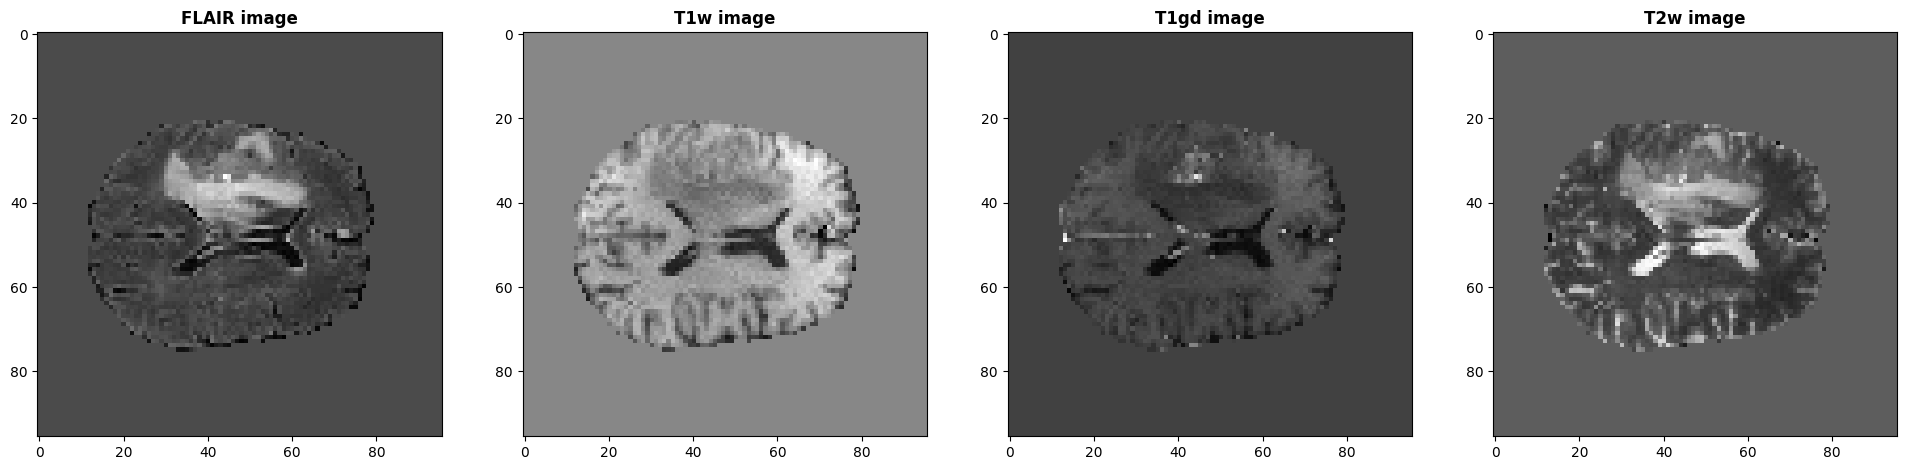

label shape: torch.Size([3, 96, 96, 96])


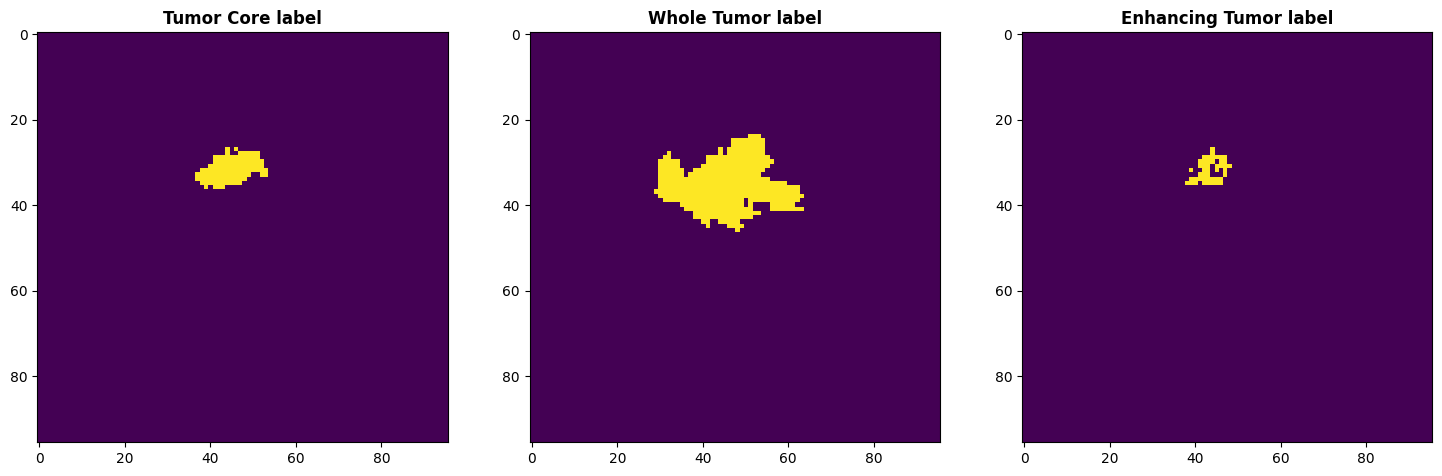

In [21]:
image_channels = ['FLAIR', 'T1w', 'T1gd', 'T2w']
label_channels = ['Tumor Core', 'Whole Tumor', 'Enhancing Tumor']

# pick one image from BratsDataset to visualize and check the 4 channels
val_data_example = val_ds[1]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(len(image_channels)):
    plt.subplot(1, 4, i + 1)
    plt.title(f"{image_channels[i]} image", weight='bold')
    plt.imshow(val_data_example["image"][i, :, :, val_data_example['image'].shape[-1] // 2], cmap="gray")
plt.show()

# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(len(label_channels)):
    plt.subplot(1, 3, i + 1)
    plt.title(f"{label_channels[i]} label", weight='bold')
    plt.imshow(val_data_example["label"][i, :, :, val_data_example['image'].shape[-1] // 2])
plt.show()

# Check number of data

Check number of data used for training / testing / validation

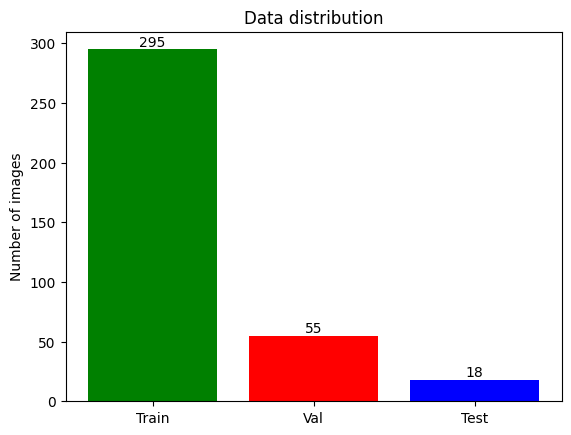

In [22]:
val_frac = val_ds.val_frac
test_frac = val_ds.test_frac

num_train = len(train_ds)
num_val = len(val_ds)
num_test = int(test_frac * num_val / val_frac)

plot_data_distribution(num_train, num_val, num_test)

# Create Model, Loss, Optimizer

In [23]:
val_interval = 1
VAL_AMP = True

# Check if CUDA (GPU support) is available
device = torch.device("cpu:0")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
print(device)

model = UNETR(
    img_shape=cfg.unetr.img_shape,
    input_dim=cfg.unetr.input_dim,
    output_dim=cfg.unetr.output_dim,
    embed_dim=cfg.unetr.embed_dim,
    patch_size=cfg.unetr.patch_size,
    num_heads=cfg.unetr.num_heads,
    dropout=0.1
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), cfg.learning_rate, weight_decay=cfg.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epoch)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold_values=True, logit_thresh=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=cfg.unetr.img_shape,
            sw_batch_size=1,
            predictor=model,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

cuda:0


# Execute a typical PyTorch training process

In [ ]:
training = True
best_metric = -1
best_metric_epoch = -1
not_improved_epoch = 0
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(cfg.epoch):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{cfg.epoch}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                not_improved_epoch = 0
                torch.save(
                    model.state_dict(),
                    os.path.join(output_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            else:
                not_improved_epoch += 1
                if not_improved_epoch >= cfg.patience:
                    training = False
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
    
    if not training:
        print("Training process is stopped early....")
        break
total_time = time.time() - total_start

----------
epoch 1/100
1/295, train_loss: 0.9673, step time: 94.7800
2/295, train_loss: 0.9487, step time: 1.0432
3/295, train_loss: 0.9791, step time: 1.0523
4/295, train_loss: 0.9574, step time: 1.0329
5/295, train_loss: 0.9534, step time: 1.0700
6/295, train_loss: 0.9824, step time: 1.0355
7/295, train_loss: 0.9918, step time: 1.0349
8/295, train_loss: 0.8475, step time: 1.0534
9/295, train_loss: 0.9496, step time: 1.1038
10/295, train_loss: 0.9875, step time: 1.0573
11/295, train_loss: 0.9769, step time: 1.0360
12/295, train_loss: 0.9424, step time: 1.0315
13/295, train_loss: 0.9444, step time: 1.0357
14/295, train_loss: 0.8786, step time: 1.0802
15/295, train_loss: 0.9584, step time: 1.0898
16/295, train_loss: 0.9761, step time: 1.0639
17/295, train_loss: 0.8587, step time: 1.0594
18/295, train_loss: 0.8989, step time: 1.0324
19/295, train_loss: 0.9213, step time: 1.0588
20/295, train_loss: 0.9811, step time: 1.0355
21/295, train_loss: 0.9840, step time: 1.0325
22/295, train_loss:

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

In [ ]:
model.load_state_dict(torch.load(os.path.join(output_dir, "best_metric_model.pth")))
model.eval()
                      
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_data = val_ds[1]
    val_input = val_data["image"].unsqueeze(0).to(device)
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_data["image"][i, :, :, val_input.shape[-1] // 2].detach().cpu(), cmap="gray")
    plt.show()
    
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_data["label"][i, :, :, val_input.shape[-1] // 2].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, val_input.shape[-1] // 2].detach().cpu())
    plt.show()

# Evaluation on test image

In [ ]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=["bilinear", "nearest"]
        ),
        Resized(keys=["image", "label"], spatial_size=cfg.unetr.img_shape, mode="nearest"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

test_ds = BratsDataset(
    root_dir=root_dir,
    section="test",
    transform=transform,
    cache_num=0
)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4)

In [ ]:
model.load_state_dict(torch.load(os.path.join(output_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_loader:
        test_inputs, test_labels = (
            test_data["image"].to(device),
            test_data["label"].to(device),
        )
        test_outputs = inference(test_inputs)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]
        dice_metric(y_pred=test_outputs, y=test_labels)
        dice_metric_batch(y_pred=test_outputs, y=test_labels)

    metric = dice_metric.aggregate().item()
    metric_batch = dice_metric_batch.aggregate()

    dice_metric.reset()
    dice_metric_batch.reset()

metric_tc, metric_wt, metric_et = metric_batch[0].item(), metric_batch[1].item(), metric_batch[2].item()

print("Metric on test image: ", metric)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")